In [67]:
import requests
import torch
import json

# Directories
img_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/'
ann_dir = 'https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/'
train_annotation_path = f'{ann_dir}train.json'
val_annotation_path = f'{ann_dir}val.json'
test_annotation_path = f'{ann_dir}test.json'

# Device configuration
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
# Load annotation data
def load_annotations(url):
    response = requests.get(url, allow_redirects=True)
    return response.json()

train_data = load_annotations(train_annotation_path)
val_data = load_annotations(val_annotation_path)
test_data = load_annotations(test_annotation_path)

print(f'Train set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')


mps
Train set size: 20523
Validation set size: 4319
Test set size: 8000


In [68]:
# Taking 8000 samples from the train data
train_subset = train_data[:8000]
# Taking 300 samples from the val data
val_subset = val_data[:300]

# Taking 100 samples from the test data
test_subset = test_data[:100]


In [69]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load Word2Vec model (50D embeddings)
word2vec_model = api.load("glove-wiki-gigaword-50")

# Initialize text preprocessing tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_text_embedding(text):
    """Converts input text into a 50D Word2Vec vector after preprocessing."""
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]  # Lemmatize, remove stopwords and non-alphanumeric tokens
    word_vectors = [word2vec_model[w] for w in words if w in word2vec_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(50)

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize without center cropping
    transforms.RandomHorizontalFlip(p=0.5),  # Augment: Flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augment: Adjust colors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])

# Load images and convert to tensors
folder_path = "/Users/darshanvijayaraghavan/Downloads/train"
image_tensors = []
question_embeddings = []

for sample in train_subset:
    # Load and transform image
    image_path = os.path.join(folder_path, sample['image'])
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    image_tensors.append(img_tensor)

    # Convert question to Word2Vec embedding
    question_embeddings.append(get_text_embedding(sample['question']))

# Convert lists to PyTorch tensors
image_tensors = torch.stack(image_tensors).to(device)
question_tensors = torch.tensor(question_embeddings, dtype=torch.float32).to(device)

print(f'Train images shape: {image_tensors.shape}')
print(f'Train question embeddings shape: {question_tensors.shape}')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/darshanvijayaraghavan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train images shape: torch.Size([8000, 3, 128, 128])
Train question embeddings shape: torch.Size([8000, 50])


In [70]:
from collections import Counter

chosen_answers = []
top_n = 300

# Choose the most common answer from the ten labels
for sample in train_subset:
    answers = [entry['answer'] for entry in sample['answers']]
    answer_counts = Counter(answers) # set up counter
    top_answer, _ = answer_counts.most_common(1)[0] # get top answer out of the ten
    chosen_answers.append(top_answer)

# Count the frequency of answers for all samples
answer_counts = Counter(chosen_answers)
top_answers = answer_counts.most_common(top_n) # top n
print(top_answers)

# Create categories for top n
category_name2id = {answer:ind for ind, (answer, _) in enumerate(top_answers)}
category_id2name = {ind:answer for ind, (answer, _) in enumerate(top_answers)}
category_id2name[top_n] = 'other_categories'

output_classes = top_n + 1

[('unanswerable', 1521), ('unsuitable', 1243), ('no', 214), ('yes', 179), ('grey', 123), ('white', 120), ('black', 93), ('blue', 77), ('red', 67), ('green', 40), ('brown', 35), ('dog', 32), ('keyboard', 31), ('phone', 29), ('pink', 29), ('purple', 28), ('coca cola', 23), ('lotion', 23), ('soup', 22), ('wine', 22), ('laptop', 19), ('yellow', 19), ('pepsi', 18), ('cell phone', 16), ('shampoo', 16), ('black white', 16), ('nothing', 16), ('coffee', 15), ('orange', 14), ('remote', 14), ('corn', 14), ('chair', 14), ('water bottle', 13), ('beer', 13), ('cup', 13), ('green beans', 12), ('computer', 12), ('tv', 11), ('beans', 11), ('mountain dew', 11), ('tan', 10), ('remote control', 10), ('pen', 10), ('dr pepper', 9), ('door', 9), ('water', 9), ('cookies', 9), ('computer mouse', 9), ('apple', 9), ('plant', 9), ('soda', 9), ('cat', 9), ('table', 9), ('hand sanitizer', 9), ('candy', 8), ('flowers', 8), ('chicken', 8), ('cereal', 8), ('tomato sauce', 8), ('money', 8), ('can', 8), ('20', 8), ('boo

In [71]:
targets = []

for ans in chosen_answers:
    if ans in category_name2id.keys():
        targets.append(category_name2id[ans])
    else:
        targets.append(top_n) # if not in top n, use the n+1 th category

targets_tensor = torch.tensor(targets)
print('Target size:', targets_tensor.shape)

Target size: torch.Size([8000])


In [72]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, images, questions, targets):
        self.images = images
        self.questions = questions
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.images[idx], self.questions[idx], self.targets[idx]

# Assuming image_tensors, question_tensors, and targets_tensor are already defined
dataset = VQADataset(image_tensors, question_tensors, targets_tensor)

# Create DataLoader with batch size 16
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [73]:
# Load validation images and convert to tensors
val_folder_path = "/Users/darshanvijayaraghavan/Downloads/val"
val_image_tensors = []
val_question_embeddings = []

for sample in val_subset:
    # Load and transform image
    val_image_path = os.path.join(val_folder_path, sample['image'])
    val_img = Image.open(val_image_path).convert("RGB")
    val_img_tensor = transform(val_img)
    val_image_tensors.append(val_img_tensor)

    # Convert question to Word2Vec embedding
    val_question_embeddings.append(get_text_embedding(sample['question']))

# Convert lists to PyTorch tensors
val_image_tensors = torch.stack(val_image_tensors).to(device)
val_question_tensors = torch.tensor(val_question_embeddings, dtype=torch.float32).to(device)


print(f'Validation images shape: {val_image_tensors.shape}')
print(f'Validation question embeddings shape: {val_question_tensors.shape}')


Validation images shape: torch.Size([300, 3, 128, 128])
Validation question embeddings shape: torch.Size([300, 50])


In [74]:

val_targets = torch.tensor([sample['answerable'] for sample in val_subset], dtype=torch.float32).to(device)
val_dataset = VQADataset(val_image_tensors, val_question_tensors, val_targets)


In [75]:
 # Implement the given metric
def calculate_accuracy(predicted_answer, human_answers):

    # Normalize answers (to lowercase)
    predicted_answer = predicted_answer.lower()
    human_answers = [answer['answer'].lower() for answer in human_answers]

    # Get the count of humans who agreed with the predicted answer
    answer_counts = Counter(human_answers)
    humans_agreed = answer_counts.get(predicted_answer, 0)

    # Calculate accuracy: min(# humans who agreed / 3, 1)
    accuracy = min(humans_agreed / 3, 1)

    return accuracy

# Process all results for your score
def evaluation_server(predicted_answer, annotations):
    accs = []
    for pred, ann in zip(predicted_answer, annotations):
        accs.append(calculate_accuracy(pred, ann['answers']))
    return np.mean(accs)

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class ImprovedVQAModel(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=None, num_heads=2, dropout_rate=0.2):
        super(ImprovedVQAModel, self).__init__()

        # Image feature extraction (ResNet34 backbone)
        self.cnn = models.resnet34(pretrained=True)
        for param in list(self.cnn.parameters())[:-8]:
            param.requires_grad = False
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, hidden_dim)

        # Text feature extraction
        self.text_embedding = nn.Sequential(
            nn.Linear(50, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Multi-head Attention
        self.img_to_text_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.text_to_img_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)

        # Normalization layers
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Gated Fusion Mechanism
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, text):
        # Image feature extraction
        img_features = self.cnn(image)  # [batch_size, hidden_dim]

        # Text feature extraction
        text_features = self.text_embedding(text)  # [batch_size, hidden_dim]

        # Prepare features for attention
        img_features_attn = img_features.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        text_features_attn = text_features.unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Cross-modal attention
        attended_text, _ = self.img_to_text_attention(
            query=img_features_attn,
            key=text_features_attn,
            value=text_features_attn
        )
        attended_img, _ = self.text_to_img_attention(
            query=text_features_attn,
            key=img_features_attn,
            value=img_features_attn
        )

        # Apply normalization
        attended_text = self.norm1(attended_text).squeeze(1)  # [batch_size, hidden_dim]
        attended_img = self.norm2(attended_img).squeeze(1)  # [batch_size, hidden_dim]

        # Gated fusion mechanism
        concat_features = torch.cat([attended_text, attended_img], dim=1)  # [batch_size, hidden_dim * 2]
        gate_value = self.gate(concat_features)
        fused_features = gate_value * attended_text + (1 - gate_value) * attended_img  # [batch_size, hidden_dim]

        # Classification
        logits = self.classifier(fused_features)  # [batch_size, num_classes]

        return logits

def train_improved_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, weight_decay=1e-5, momentum=0.9)

    best_val_acc = 0.0

    # Lists to store metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, questions, targets in train_loader:
            images, questions, targets = images.to(device), questions.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        model.eval()

        with torch.no_grad():
            images = val_image_tensors.to(device)
            questions = val_question_tensors.to(device)
            outputs = model(images, questions)
            _, predicted = torch.max(outputs, 1)

        predictions = predicted.cpu().numpy()
        answers = [category_id2name[pred] for pred in predictions]
        score = evaluation_server(answers, val_subset)
        val_accuracies.append(score)
        print(f"Val Acc: {score:.4f}")

        if score > best_val_acc:
            best_val_acc = score
            torch.save(model.state_dict(), 'best_vqa_model.pth')
            print(f"New best model saved with validation accuracy: {score:.4f}")

        # Plot training and validation accuracy and loss
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    print("Avg validation Accuracy: {:.4f}".format(np.mean(val_accuracies)))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch [1/10] Train Loss: 3.4182, Train Acc: 0.3111
Val Acc: 0.0000
Epoch [2/10] Train Loss: 2.8756, Train Acc: 0.3486
Val Acc: 0.1511
New best model saved with validation accuracy: 0.1511
Epoch [3/10] Train Loss: 2.7781, Train Acc: 0.3666
Val Acc: 0.2011
New best model saved with validation accuracy: 0.2011
Epoch [4/10] Train Loss: 2.6907, Train Acc: 0.3930
Val Acc: 0.2500
New best model saved with validation accuracy: 0.2500
Epoch [5/10] Train Loss: 2.6219, Train Acc: 0.4065
Val Acc: 0.3611
New best model saved with validation accuracy: 0.3611
Epoch [6/10] Train Loss: 2.5640, Train Acc: 0.4159
Val Acc: 0.2189
Epoch [7/10] Train Loss: 2.5190, Train Acc: 0.4288
Val Acc: 0.2856
Epoch [8/10] Train Loss: 2.4780, Train Acc: 0.4368
Val Acc: 0.1411
Epoch [9/10] Train Loss: 2.4384, Train Acc: 0.4465
Val Acc: 0.2800
Epoch [10/10] Train Loss: 2.3954, Train Acc: 0.4569
Val Acc: 0.2644
Avg validation Accuracy: 0.2153


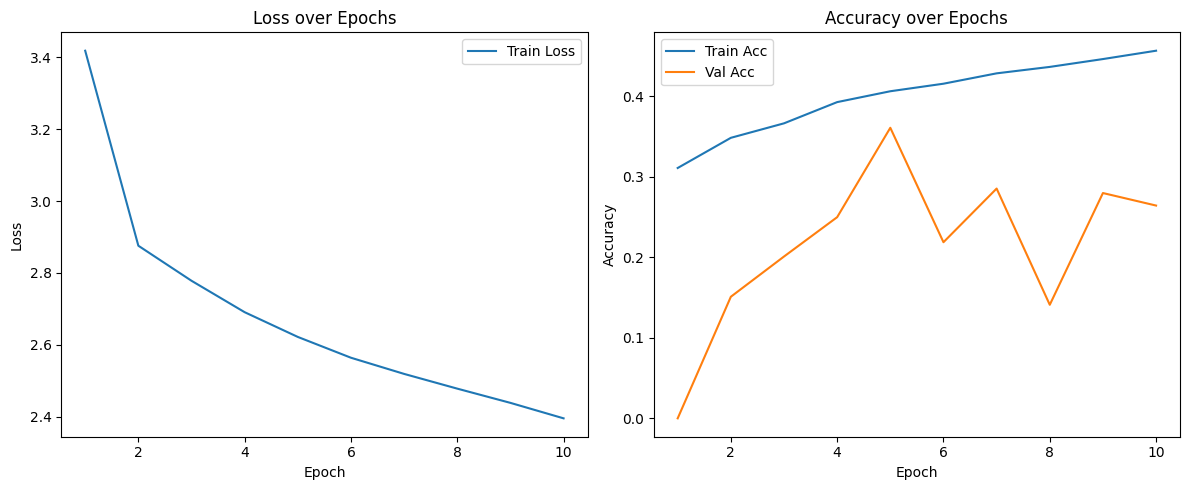

In [77]:
train_dataset = VQADataset(image_tensors, question_tensors, targets_tensor)
batch_size = 32

# Create both train and validation loaders
# For validation, you should use your val_subset data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = ImprovedVQAModel(
    hidden_dim=256,         # Increase if you have enough GPU memory
    num_classes=output_classes,
    dropout_rate=0.2
).to(device)

# 5. Train the model
trained_model = train_improved_model(
    model=model,
    train_loader=train_loader,
    num_epochs=10
)

In [78]:
# Define the test dataset folder
test_folder_path = "/Users/darshanvijayaraghavan/Downloads/test"
test_image_tensors = []
test_question_embeddings = []

for sample in test_subset:
    # Load and transform image
    test_image_path = os.path.join(test_folder_path, sample['image'])
    test_img = Image.open(test_image_path).convert("RGB")
    test_img_tensor = transform(test_img)
    test_image_tensors.append(test_img_tensor)

    # Convert question to Word2Vec embedding
    test_question_embeddings.append(get_text_embedding(sample['question']))

# Convert lists to PyTorch tensors
test_image_tensors = torch.stack(test_image_tensors).to(device)
test_question_tensors = torch.tensor(test_question_embeddings, dtype=torch.float32).to(device)

print(f'Test images shape: {test_image_tensors.shape}')
print(f'Test question embeddings shape: {test_question_tensors.shape}')


Test images shape: torch.Size([100, 3, 128, 128])
Test question embeddings shape: torch.Size([100, 50])


In [80]:
model = ImprovedVQAModel(hidden_dim=256, num_classes=301, dropout_rate=0.2)
model.load_state_dict(torch.load('best_vqa_model.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    images = test_image_tensors.to(device)
    questions = test_question_tensors.to(device)
    outputs = model(images, questions)
    _, predicted = torch.max(outputs, 1)

predictions = predicted.cpu().numpy()

image_names = [sample['image'] for sample in test_subset]
answers = [category_id2name[pred] for pred in predictions]
results = [{'image':image, 'answer':ans} for image, ans in zip(image_names, answers)]

print('Check the format for the first sample:', results[0])

import json

# Save predictions to JSON file
output_filename = "Darshan_Vijayaraghavan_challenge2.json"
with open(output_filename, "w") as f:
    json.dump(results, f, indent=4)

print(f"Predictions saved to {output_filename}")


Check the format for the first sample: {'image': 'VizWiz_test_00000000.jpg', 'answer': 'grey'}
Predictions saved to Darshan_Vijayaraghavan_challenge2.json
